## Grid Independent Test

In [2]:
import numpy as np

class Grid:
    """Class defining a one-dimensional Cartesian grid"""
    
    def __init__(self, lx, ly, lz, ncv):
        """Constructor
            lx .... total length of domain in x-direction [m]
            ly .... total length of domain in y-direction [m]
            lz .... total length of domain in z-direction [m]
            ncv ... number of control volumes in domain
        """
        # Store the number of control volumes
        self._ncv = ncv
        
        # Calculate the control volume length
        dx = lx/float(ncv)
        
        # Calculate the face locations
        self._xf = np.array([i*dx for i in range(ncv+1)])
        
        # Calculate the cell centroid locations
        self._xP = np.array([self._xf[0]] + 
                            [0.5*(self._xf[i]+self._xf[i+1]) for i in range(ncv)] +
                            [self._xf[-1]])
        
        # Calculate face areas
        self._Af = ly*lz*np.ones(ncv+1)
        
        # Calculate the outer surface area for each cell
        self._Ao = (2.0*dx*ly + 2.0*dx*lz)*np.ones(ncv)
        
        # Calculate cell volumes
        self._vol = dx*ly*lz*np.ones(ncv)
        
    @property
    def ncv(self):
        """Number of control volumes in domain"""
        return self._ncv
    
    @property
    def xf(self):
        """Face location array"""
        return self._xf
    
    @property
    def xP(self):
        """Cell centroid array"""
        return self._xP
    
    @property
    def dx_WP(self):
        return self.xP[1:-1]-self.xP[0:-2]
        
    @property
    def dx_PE(self):
        return self.xP[2:]-self.xP[1:-1]
      
    @property
    def Af(self):
        """Face area array"""
        return self._Af

    @property
    def Aw(self):
        """West face area array"""
        return self._Af[0:-1]
    
    @property
    def Ae(self):
        """East face area array"""
        return self._Af[1:]
    
    @property
    def Ao(self):
        """Outer face area array"""
        return self._Ao
    
    @property
    def vol(self):
        """Cell volume array"""
        return self._vol
    
    
class ScalarCoeffs:
    """Class defining the set of coefficients for a finite-volume discretization
       of a scalar partial differential equation.
    """
    
    def __init__(self, ncv):
        """Constructor
            ncv ... number of control volumes in domain
        """
        self._ncv = ncv
        self._aP = np.zeros(ncv)
        self._aW = np.zeros(ncv)
        self._aE = np.zeros(ncv)
        self._rP = np.zeros(ncv)
        
    def zero(self):
        """Function to zero the coefficient arrays"""
        self._aP.fill(0.0)
        self._aW.fill(0.0)
        self._aE.fill(0.0)
        self._rP.fill(0.0)
        
    def accumulate_aP(self, aP):
        """Function to accumulate values onto aP"""
        self._aP += aP
        
    def accumulate_aW(self, aW):
        """Function to accumulate values onto aW"""
        self._aW += aW

    def accumulate_aE(self, aE):
        """Function to accumulate values onto aE"""
        self._aE += aE
        
    def accumulate_rP(self, rP):
        """Function to accumulate values onto rP"""
        self._rP += rP
        
    @property
    def ncv(self):
        """Number of control volumes in domain"""
        return self._ncv
        
    @property
    def aP(self):
        """Cell coefficient"""
        return self._aP
    
    @property
    def aW(self):
        """West cell coefficient"""
        return self._aW
    
    @property
    def aE(self):
        """East cell coefficient"""
        return self._aE
    
    @property
    def rP(self):
        """Cell residual"""
        return self._rP
    
    
from enum import Enum

class BoundaryLocation(Enum):
    """Enumeration class defining boundary condition locations"""
    WEST = 1
    EAST = 2
    
    
class DirichletBc:
    """Class defining a Dirichlet boundary condition"""
    
    def __init__(self, phi, grid, value, loc):
        """Constructor
            phi ..... field variable array
            grid .... grid
            value ... boundary value
            loc ..... boundary location
        """
        self._phi = phi
        self._grid = grid
        self._value = value
        self._loc = loc
        
    def value(self):
        """Return the boundary condition value"""
        return self._value
    
    def coeff(self):
        """Return the linearization coefficient"""
        return 0
    
    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = self._value
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = self._value
        else:
            raise ValueError("Unknown boundary location")
            
            
            
class DiffusionModel:
    """Class defining a diffusion model"""
    
    def __init__(self, grid, phi, gamma, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._gamma = gamma
        self._west_bc = west_bc
        self._east_bc = east_bc
        
    def add(self, coeffs):
        """Function to add diffusion terms to coefficient arrays"""
        
        # Calculate the west and east face diffusion flux terms for each face
        flux_w = - self._gamma*self._grid.Aw*(self._phi[1:-1]-self._phi[0:-2])/self._grid.dx_WP
        flux_e = - self._gamma*self._grid.Ae*(self._phi[2:]-self._phi[1:-1])/self._grid.dx_PE
        
        # Calculate the linearization coefficients
        coeffW = - self._gamma*self._grid.Aw/self._grid.dx_WP
        coeffE = - self._gamma*self._grid.Ae/self._grid.dx_PE
        coeffP = - coeffW - coeffE
        
        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()
        
        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0
        
        # Calculate the net flux from each cell
        flux = flux_e - flux_w
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        
        # Return the modified coefficient array
        return coeffs
    
    
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix

def get_sparse_matrix(coeffs):
    """Function to return a sparse matrix representation of a set of scalar coefficients"""
    ncv = coeffs.ncv
    data = np.zeros(3*ncv-2)
    rows = np.zeros(3*ncv-2, dtype=int)
    cols = np.zeros(3*ncv-2, dtype=int)
    data[0] = coeffs.aP[0]
    data[1] = coeffs.aE[0]
    rows[0] = 0
    cols[0] = 0
    rows[1] = 0
    cols[1] = 1
    for i in range(ncv-2):
        data[3*i+2] = coeffs.aW[i+1]
        data[3*i+3] = coeffs.aP[i+1]
        data[3*i+4] = coeffs.aE[i+1]
        rows[3*i+2:3*i+5] = i+1
        cols[3*i+2] = i
        cols[3*i+3] = i+1
        cols[3*i+4] = i+2
    data[3*ncv-4] = coeffs.aW[-1]
    data[3*ncv-3] = coeffs.aP[-1]
    rows[3*ncv-4:3*ncv-2] = ncv-1
    cols[3*ncv-4] = ncv-2
    cols[3*ncv-3] = ncv-1
    return csr_matrix((data, (rows, cols)))

def solve(coeffs):
    """Function to solve the linear system and return the correction field"""
    # Get the sparse matrix
    A = get_sparse_matrix(coeffs)
    # Solve the linear system
    return spsolve(A, -coeffs.rP)



class ImplicitRadiationModel:
    """Class defining a radiation model"""
    
    def __init__(self, grid, T, To, sigma, epsilon):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._To = To
        self._sigma = sigma
        self._epsilon = epsilon
        
    def add(self, coeffs):
        """Function to add surface convection terms to coefficient arrays"""
        
        # Calculate the source term
        source = self._sigma*self._epsilon*self._grid.Ao*(self._T[1:-1]**4 - self._To**4) 
        # Calculate the linearization coefficients
        coeffP = 4*self._sigma*self._epsilon*self._grid.Ao*self._T[1:-1]**3
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(source)
        
        return coeffs
    
    
def problem4(ncv):
    import numpy as np
    from numpy.linalg import norm

    # Set the maximum number of iterations and convergence criterion
    maxIter = 100
    converged = 1e-15

    # Define thermophysical properties
    k = 0.1
    sigma = 5.67e-8
    epsilon = 1
    
    # Define freestream temp.
    To = 0

    # Define the coefficients
    coeffs = ScalarCoeffs(grid.ncv)

    # Initial conditions
    T0 = 100

    # Initialize field variable arrays
    T = T0*np.ones(grid.ncv+2)

    # Define boundary conditions
    west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
    east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)

    # Apply boundary conditions
    west_bc.apply()
    east_bc.apply()

    # Define the diffusion model
    diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

    # Define the surface convection model
    Radiation = ImplicitRadiationModel(grid, T, To, sigma, epsilon)

    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = Radiation.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        if maxResid < converged:
            break

        # Solve the sparse matrix system
        dT = solve(coeffs)

        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()

    return T

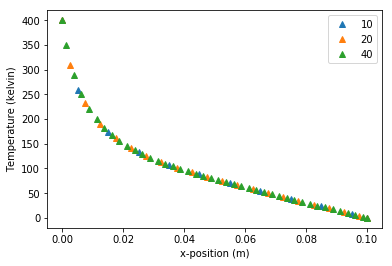

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
ncv= 10
lx = 0.1
ly = 0.005
lz = 0.005
xPosition=[]
Te=[]

for i in range(3):
    grid = Grid(lx, ly, lz, ncv)
    xPosition.append(grid.xP)
    Te.append(problem4(ncv))
    ncv*=2
z = 0
for x, T in zip(xPosition, Te):
    # To store the length of each array in xPosition
    r=len(xPosition[z])
    #(r-2): ncv i always 2 less than xPosition
    plt.plot(x, T, '^', label=str(r-2))
    z+=1
plt.xlabel("x-position (m)")
plt.ylabel("Temperature (kelvin)")
plt.legend()
plt.show()

Results are almost overlapping for all ncv. But as radiation term is non linear, it is better to take higher number of control volumes. For this problem we will take ncv = 40.

## Sensitivity to Convergence Criteria

Value of residual indicates how well the fluxes are balanced. To observe the effect of residual, here we will plot the temperature (at x = 0.02625 m) against the value of residuals.

In [4]:
def rP(converged):
    import numpy as np
    from numpy.linalg import norm

    # Set the maximum number of iterations and convergence criterion
    maxIter = 100

    # Define thermophysical properties
    k = 0.1
    sigma = 5.67e-8
    epsilon = 1
    
    # Define freestream temp.
    To = 0

    # Define the coefficients
    coeffs = ScalarCoeffs(grid.ncv)

    # Initial conditions
    T0 = 100

    # Initialize field variable arrays
    T = T0*np.ones(grid.ncv+2)

    # Define boundary conditions
    west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
    east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)

    # Apply boundary conditions
    west_bc.apply()
    east_bc.apply()

    # Define the diffusion model
    diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

    # Define the surface convection model
    Radiation = ImplicitRadiationModel(grid, T, To, sigma, epsilon)

    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = Radiation.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        if maxResid < converged:
            break

        # Solve the sparse matrix system
        dT = solve(coeffs)

        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()

    return T
    

[129.3208601057739, 129.32084854381046, 129.32084854381046, 129.32084854380943, 129.32084854380943, 129.32084854380943]


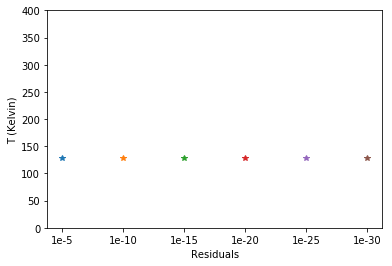

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
# Define residual values
C = [1e-6, 1e-10, 1e-15, 1e-20, 1e-25, 1e-30]
# To store the value of temperature from function rP
x=[]
# Following two array is used to seperate and store the temperature at point of interest.
Tx = []
y = []

for i in range(6):
    # Define grid
    grid=Grid(0.1, 0.005, 0.005, 40)
    x.append(rP(C[i]))
for k in range(6):
    Tx = x[k]
    y.append(Tx[11])
# To print the temperature for different residuals.
print(y)
# To plot points
av=1
for d in range(6):
     plt.plot(av,y[d],'*')
     av+=1
plt.ylim(0,400)
plt.xticks([1, 2, 3, 4, 5, 6],['1e-5', '1e-10', '1e-15', '1e-20', '1e-25', '1e-30'])
plt.xlabel('Residuals')
plt.ylabel('T (Kelvin)')
plt.show()

Change in result is negligible. In this problem, we will use residual as 1e-10.

## Final Code

In [6]:
import numpy as np
from numpy.linalg import norm
# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 40
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-10

# Define thermophysical properties
k = 0.1

# Define convection parameters
To = 0
sigma = 5.67e-8
epsilon = 1
# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 100

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()


# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
Radiation = ImplicitRadiationModel(grid, T, To, sigma, epsilon)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = Radiation.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()


Iteration = 0; Max. Resid. = 0.5997165; Avg. Resid. = 0.020269324999999994
Iteration = 1; Max. Resid. = 0.057260002621826164; Avg. Resid. = 0.004922292438572508
Iteration = 2; Max. Resid. = 0.005149376161412464; Avg. Resid. = 0.0007266259086506413
Iteration = 3; Max. Resid. = 0.00029223753849381886; Avg. Resid. = 5.470807183801907e-05
Iteration = 4; Max. Resid. = 2.608312833259161e-06; Avg. Resid. = 6.732693962956159e-07
Iteration = 5; Max. Resid. = 5.047472888871501e-10; Avg. Resid. = 1.6286612481905539e-10
Iteration = 6; Max. Resid. = 7.632783294297951e-17; Avg. Resid. = 1.7665266936857416e-17


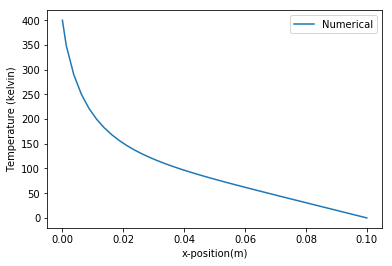

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
# plot numerical result
plt.plot(grid.xP, T,label='Numerical')
plt.xlabel("x-position(m)")
plt.ylabel("Temperature (kelvin)")
plt.legend()
plt.show()